In [34]:
import polars as pl
import seaborn as sb
import gtfs_delay_analysis as da

In [32]:
import importlib
importlib.reload(da)

<module 'gtfs_delay_analysis' from '/home/chrlz/repos/GTFS/gtfs_delay_analysis/__init__.py'>

In [2]:
stops = pl.read_csv(
    '/home/chrlz/dox/dl/ETS_Bus_Schedule_GTFS_Data_Feed_-_Stops_20240216.csv')

In [3]:
aggregated = da.load_aggregate_data()

So we know that all trip id is unique for a single day, no need to worry about overlaps

Average delay in a stop every 3 minutes 10 recordings of a bus

AM: 7am-9am
PM: 4pm-7pm
OFF: 5am-7am, 9am-4-pm, 7pm-10pm

In [5]:
# 1. Map delay average over week
mean_stop = aggregated.pipe(da.agg_group, 'stopid')

# 2. Over week by day
# TODO: Filter by PEAK, OFF, and DAY
by_day_all = aggregated.pipe(da.agg_group, 'day', 'period')
by_day_peak = (
    aggregated
    .filter(pl.col('period') != 'OFF')
    .pipe(da.agg_group, 'day', 'period')
)
by_day_off = (
    aggregated
    .filter(pl.col('period') == 'OFF')
    .pipe(da.agg_group, 'day', 'period')
)


# 3. Over day by hour
by_hour = aggregated.pipe(da.agg_group, 'day', 'hour')

# TODO: Select route
# 4. Time series graph of route by hour by day


highest_delay_stops = (
    mean_stop
    .group_by('stopid')
    .agg(pl.col('avgdelay').max())
    .sort('avgdelay', descending=True)
    .select('stopid')
    .head(100)
    .unique()
    .join(aggregated, on='stopid')
)
routes_on_highest_delay_stops = (
    highest_delay_stops
    .select('routeid')
    .unique()
    .join(aggregated, on='routeid')
)
agg_routes_on_highest_delay = (
    routes_on_highest_delay_stops
    .pipe(da.agg_group, 'routeid')
    .drop('lastupdate')
)


def plot_by_route(df: pl.DataFrame):
    tidy = df.melt(id_vars='routeid').sort('routeid')
    xticks = tidy['routeid']
    xticks_unique = tidy['routeid'].unique()
    ax = sb.barplot(
        data=tidy,
        x='routeid',
        y='value',
        hue='variable',
        width=1,
        order=xticks,
    )
    ax.set_xticks(ax.get_xticks(), xticks_unique, rotation=90)


# 5. Mapping delay propagations within a route
# 6. TODO

def plot_stop_and_route(df: pl.DataFrame, stop: str, route: str):
    days = pl.DataFrame({
        "day": [*range(1, 6)],
        "letter": ['M', 'T', 'W', 'R', 'F'],
    }, schema={"day": pl.Int8, 'letter': pl.Categorical})
    by_day_by_hour_for_stop = (
        da.select_stop_and_route(df, stop, route)
        .join(days, on='day')
        .drop('day')
        .rename({'letter': 'day'})
    )

    ax = sb.barplot(by_day_by_hour_for_stop, x='hour', y='avgdelay', hue='day')
    ax.set_title(f'Average delay for route {route} stop {stop}')
    return by_day_by_hour_for_stop


# select_stop(aggregated, "2260")

# sb.barplot(by_day_by_hour_for_stop, x='hour', y='maxdelay')


highest_delay_stops.select('stopid').unique()

# plot_stop_and_route(aggregated, "2260", "637")
da.select_stop(aggregated, "2260")

routeid,avgdelay,maxdelay,numtrips,count
cat,f64,f64,u32,u32
"""004""",404.895349,1188.0,430,1465
"""637""",224.375,465.0,8,24


In [10]:
(
    mean_stop.drop('lastupdate')
    .pipe(da.add_coords, stops)
    .write_csv('mean-stop.csv')
)

In [27]:
len(mean_stop) - len(mean_stop.filter(pl.col('numtrips')> 200))
# len(mean_stop)

1489

Some exploration of the `trips.json` file which DOES contain coordinates of the
trip

From initial observation of the data, each trip may have a unique path, even for
the same route (e.g. shorter route for off-peak hours, my bus route home was
like that at one point)

Other assumptions:
- There is only one type of geometry line: MultiLineString
- The actual coordinates are wrapped inside another JSON array

In [ ]:
trips = da.load_trips_df()

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
trips.sort('route_id')

In [ ]:
import geopolars as gp
gp.GeoDataFrame(mean_stop.pipe(da.add_coords, stops)).plot()


How many counts should we deem useful for visualization of data?

In [ ]:
pl.Config.set_fmt_table_cell_list_len(100)
aggregated['routeid']
# 1_250_916

hour,avgdelay,maxdelay,numtrips,count,day
i8,f64,f64,u32,u32,cat
5,82.208333,150.0,4,49,"""M"""
6,68.836142,175.0,12,137,"""M"""
7,196.82483,457.5,7,67,"""M"""
8,225.898716,867.0,16,412,"""M"""
9,270.754127,905.625,10,168,"""M"""
…,…,…,…,…,…
18,287.778834,360.0,7,143,"""F"""
19,275.515789,360.0,5,50,"""F"""
20,172.0,324.0,2,44,"""F"""


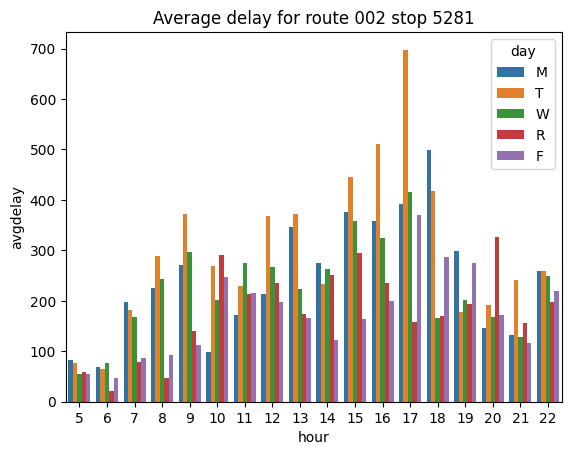

In [53]:
da.select_stop(aggregated, '5281')
# plot_stop_and_route(aggregated, '1899', '560')
# plot_stop_and_route(aggregated, '1899', '413')
# plot_stop_and_route(aggregated, '5281', '002')
# plot_stop_and_route(aggregated, '5281', '004')
# plot_stop_and_route(aggregated, '5281', '904')